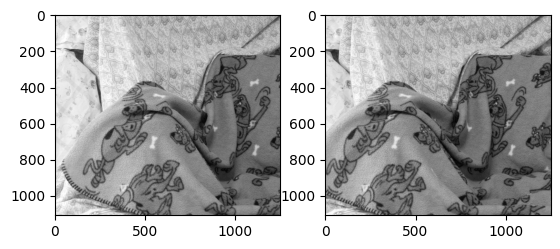

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Считываем левое и правое изображения:

imgL = cv2.imread("/content/Cloth3_Left.png", cv2.IMREAD_GRAYSCALE)  # левое изображение
imgR = cv2.imread("/content/Cloth3_Right.png",cv2.IMREAD_GRAYSCALE)  # правое изображение

fig = plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(imgL, 'gray')
plt.subplot(1,2,2)
plt.imshow(imgR, 'gray')









In [2]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(imgL, None)
kp2, des2 = orb.detectAndCompute(imgR, None)
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
flann_match_pairs = flann.knnMatch(des1, des2, k=2)

Будем игнорировать неоднозначные соответствия:

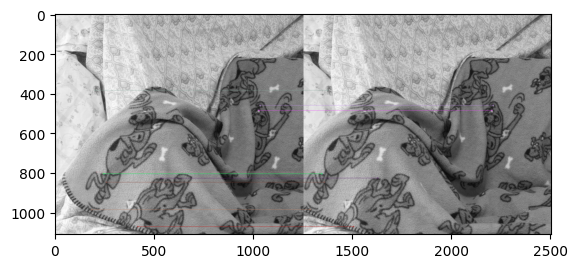

In [3]:
filtered_matches = []
ratio_threshold=0.4
for m, n in flann_match_pairs:
  if m.distance < ratio_threshold * n.distance:
    filtered_matches.append(m)

img = cv2.drawMatches(imgL,kp1,imgR,kp2,filtered_matches[:10],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img)





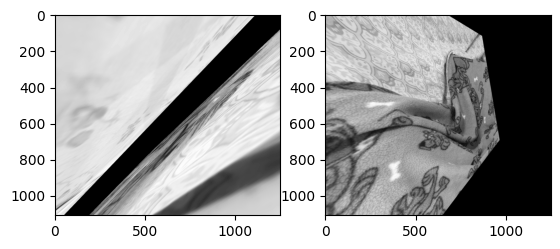

In [5]:
pts1, pts2 = [], []
fundamental_matrix, inliers = None, None
for m in filtered_matches[:10]:
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)
if pts1 and pts2:
    fundamental_matrix, inliers = cv2.findFundamentalMat(np.float32(pts1), np.float32(pts2), cv2.FM_RANSAC)

h1, w1 = imgL.shape
h2, w2 = imgR.shape
thresh = 0
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1), threshold=thresh)

imgL_undistorted = cv2.warpPerspective(imgL, H1, (w1, h1))
imgR_undistorted = cv2.warpPerspective(imgR, H2, (w2, h2))
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
dmObject = plt.imshow(imgL_undistorted, 'gray')
plt.subplot(1,2,2)
dmObject = plt.imshow(imgR_undistorted, 'gray')



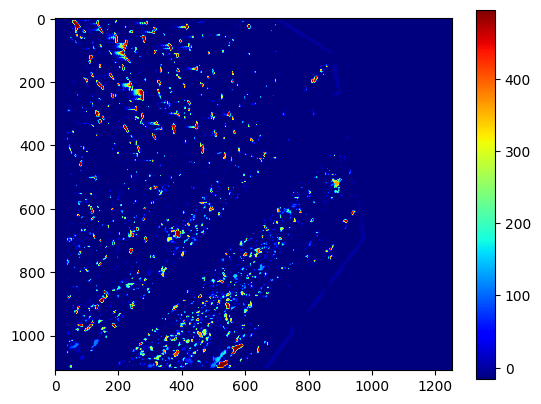

In [6]:
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
disparity_BM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_BM, aspect='equal', cmap='jet')
plt.colorbar()
plt.show()



In [7]:
import numpy as np

array = disparity_BM.copy()
array = array.flatten()
far_objects_rate = np.count_nonzero(array == min(array))/len(array)
close_objects_rate = np.count_nonzero(array == max(array))/len(array)
print('Доля наиболее отдаленных пикселей: ', far_objects_rate)
print('Доля наиболее близких пикселей: ', close_objects_rate)





Доля наиболее отдаленных пикселей:  0.9555154995250842
Доля наиболее близких пикселей:  0.010480528451774457


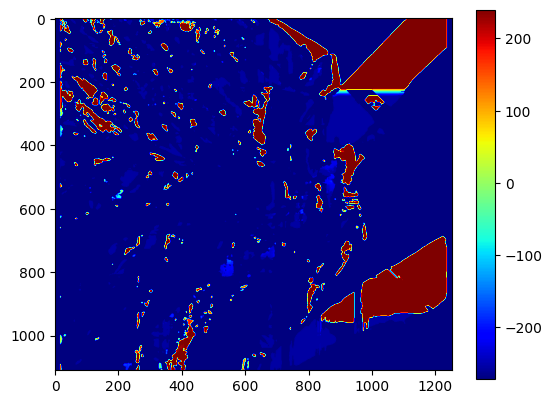

In [8]:
stereo = cv2.StereoSGBM_create(
    minDisparity=-16,
    numDisparities=32,
    blockSize=15,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * 15 ** 2,
    P2=32 * 3 * 15 ** 2,
)
disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_SGBM, aspect='equal', cmap='jet')
plt.colorbar()
plt.show()

In [9]:
array = disparity_SGBM.copy()
array = array.flatten()
far_objects_rate = np.count_nonzero(array == min(array))/len(array)
close_objects_rate = np.count_nonzero(array == max(array))/len(array)
print('Доля наиболее отдаленных пикселей: ', far_objects_rate)
print('Доля наиболее близких пикселей: ', close_objects_rate)

Доля наиболее отдаленных пикселей:  0.8170235730938606
Доля наиболее близких пикселей:  0.10997682986500878
